Epoch [1], train_loss: 2.0026, val_loss: 2.0476, val_acc: 0.2692
Epoch [2], train_loss: 1.9549, val_loss: 1.9421, val_acc: 0.3092
Epoch [3], train_loss: 2.0906, val_loss: 1.8806, val_acc: 0.3296
Epoch [4], train_loss: 1.8862, val_loss: 1.8298, val_acc: 0.3527
Epoch [5], train_loss: 1.7390, val_loss: 1.7837, val_acc: 0.3765
Epoch [6], train_loss: 1.6114, val_loss: 1.7459, val_acc: 0.3851
Epoch [7], train_loss: 1.8016, val_loss: 1.7208, val_acc: 0.3973
Epoch [8], train_loss: 1.5574, val_loss: 1.6891, val_acc: 0.4042
Epoch [9], train_loss: 1.8984, val_loss: 1.6859, val_acc: 0.4065
Epoch [10], train_loss: 1.5152, val_loss: 1.6589, val_acc: 0.4161
Epoch [11], train_loss: 1.6304, val_loss: 1.6484, val_acc: 0.4214
Epoch [12], train_loss: 1.5424, val_loss: 1.6208, val_acc: 0.4329
Epoch [13], train_loss: 1.2900, val_loss: 1.6187, val_acc: 0.4304
Epoch [14], train_loss: 1.6693, val_loss: 1.5843, val_acc: 0.4468
Epoch [15], train_loss: 1.4474, val_loss: 1.5784, val_acc: 0.4469
Epoch [16], train_l

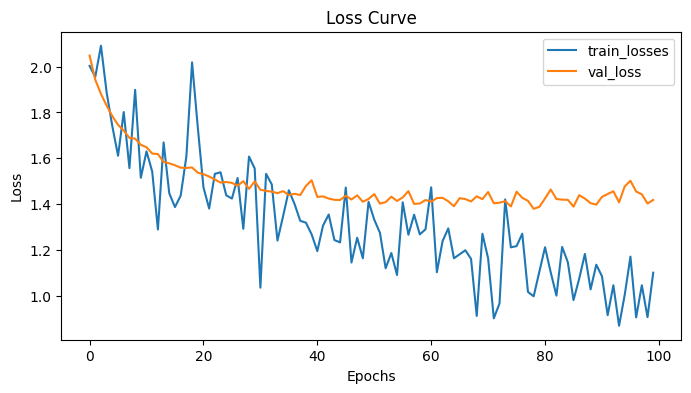

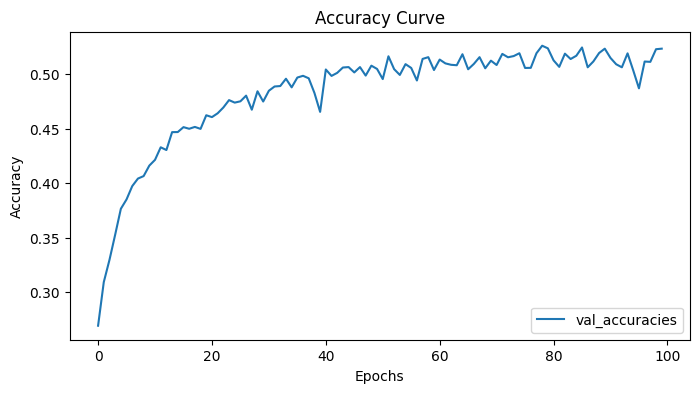

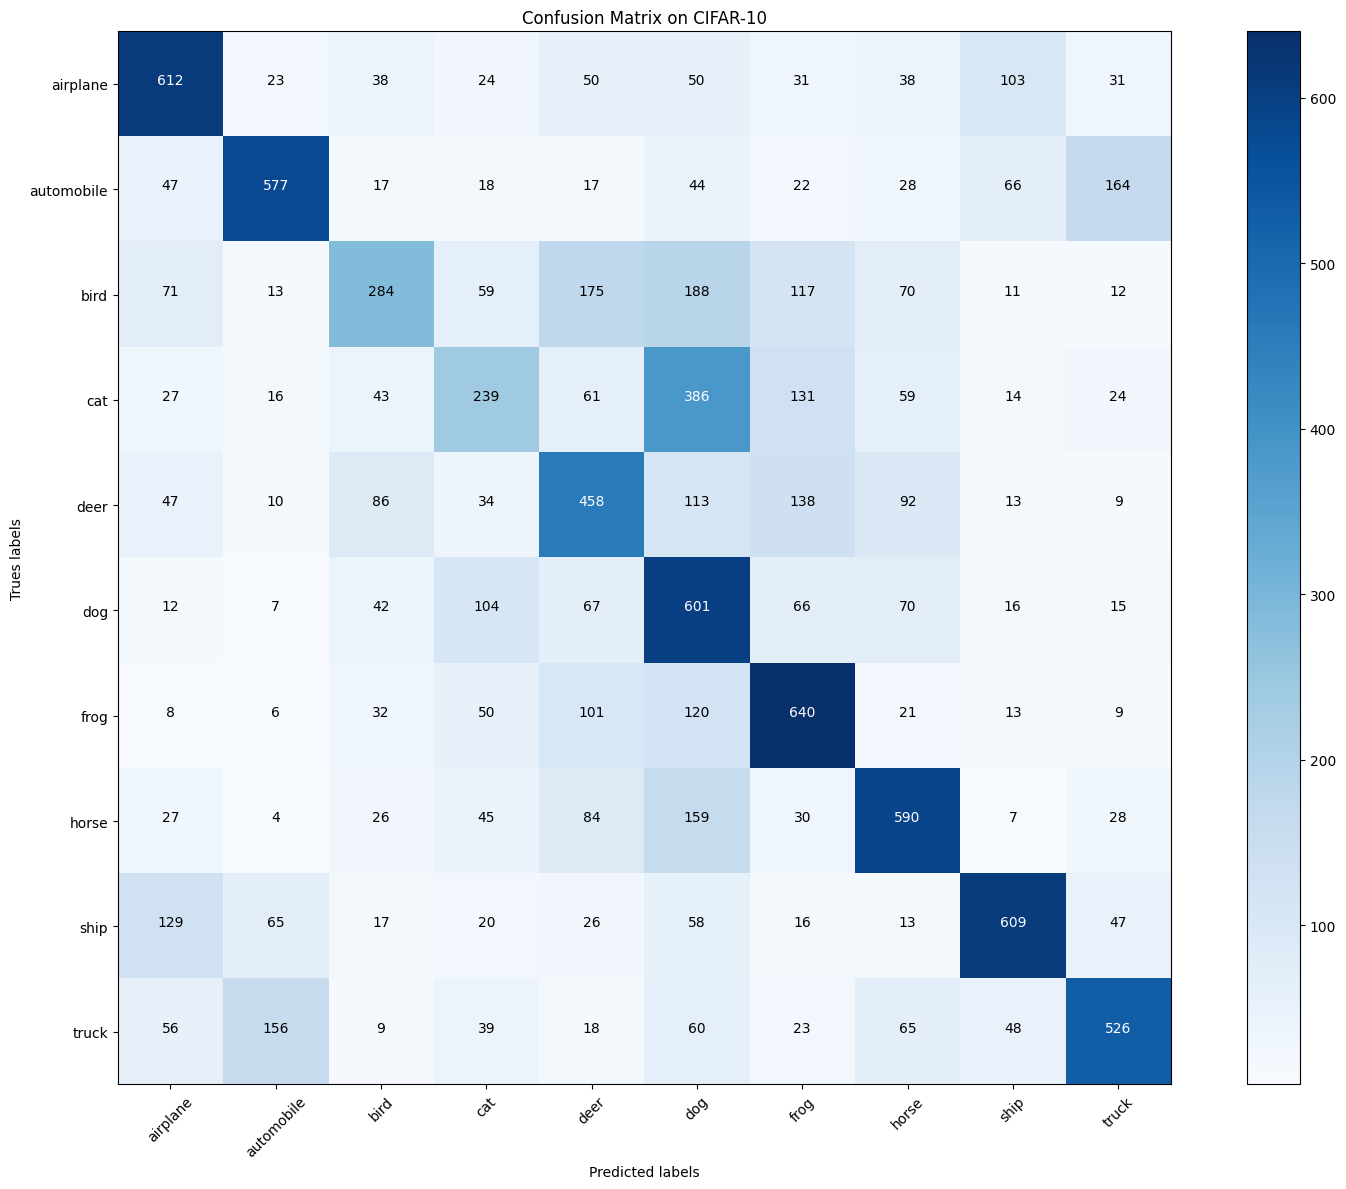

In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

# 加载 CIFAR-10 批次数据
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

# 加载所有 CIFAR-10 数据
def load_cifar10(ROOT):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b,))
        X, Y = load_cifar10_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_cifar10_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

ROOT = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10(ROOT)

# 全连接神经网络类
class FullyConnectedNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y, Y_hat):
        m = Y.shape[0]
        log_likelihood = -np.log(Y_hat[range(m), Y])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, X, Y, Y_hat):
        m = X.shape[0]
        dZ2 = Y_hat
        dZ2[range(m), Y] -= 1
        dZ2 /= m

        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)

        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def compute_accuracy(self, X, Y):
        Y_hat = self.forward(X)
        predictions = np.argmax(Y_hat, axis=1)
        accuracy = np.mean(predictions == Y)
        return accuracy

    def train(self, X_train, Y_train, X_val, Y_val, epochs=300, learning_rate=0.01):
        self.learning_rate = learning_rate
        train_losses = []
        val_losses = []
        val_accuracies = []

        for epoch in range(epochs):
            # 打乱训练数据
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            Y_train = Y_train[indices]

            # 小批量梯度下降
            for start_idx in range(0, X_train.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X_train.shape[0])
                X_batch = X_train[start_idx:end_idx]
                Y_batch = Y_train[start_idx:end_idx]

                # 前向传播
                Y_hat_train = self.forward(X_batch)
                train_loss = self.compute_loss(Y_batch, Y_hat_train)
                
                # 反向传播
                self.backward(X_batch, Y_batch, Y_hat_train)

            # 每个 epoch 结束后计算验证集上的损失和准确率
            Y_hat_val = self.forward(X_val)
            val_loss = self.compute_loss(Y_val, Y_hat_val)
            val_accuracy = self.compute_accuracy(X_val, Y_val)
            
            # 存储损失和准确率
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # 打印每个 epoch 的损失和准确率
            print(f'Epoch [{epoch + 1}], train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_accuracy:.4f}')
        
        return train_losses, val_losses, val_accuracies

# 预处理数据
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# 将训练数据分成训练集和验证集
split_index = int(0.8 * X_train.shape[0])
X_val, y_val = X_train[split_index:], y_train[split_index:]
X_train, y_train = X_train[:split_index], y_train[:split_index]

# 超参数
input_size = 3072  # 32*32*3
hidden_size = 128
output_size = 10
learning_rate = 0.01
epochs = 100
batch_size = 64

# 初始化并训练模型
model = FullyConnectedNN(input_size, hidden_size, output_size)
train_losses, val_losses, val_accuracies = model.train(X_train, y_train, X_val, y_val, epochs, learning_rate)

# 在测试集上进行预测
y_pred = np.argmax(model.forward(X_test), axis=1)
accuracy = np.mean(y_pred == y_test)
print(f'测试集准确率: {accuracy:.4f}')

# 绘制损失曲线
epochs_range = range(epochs)
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label='train_losses')
plt.plot(epochs_range, val_losses, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')
plt.show()

# 绘制准确率曲线
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, val_accuracies, label='val_accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')
plt.show()


# 计算混淆矩阵
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, title='Confusion Matrix on CIFAR-10', cmap=plt.cm.Blues):
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Trues labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

# CIFAR-10 标签
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 计算并绘制混淆矩阵
cm = compute_confusion_matrix(y_test, y_pred, len(cifar10_labels))
plot_confusion_matrix(cm, classes=cifar10_labels)


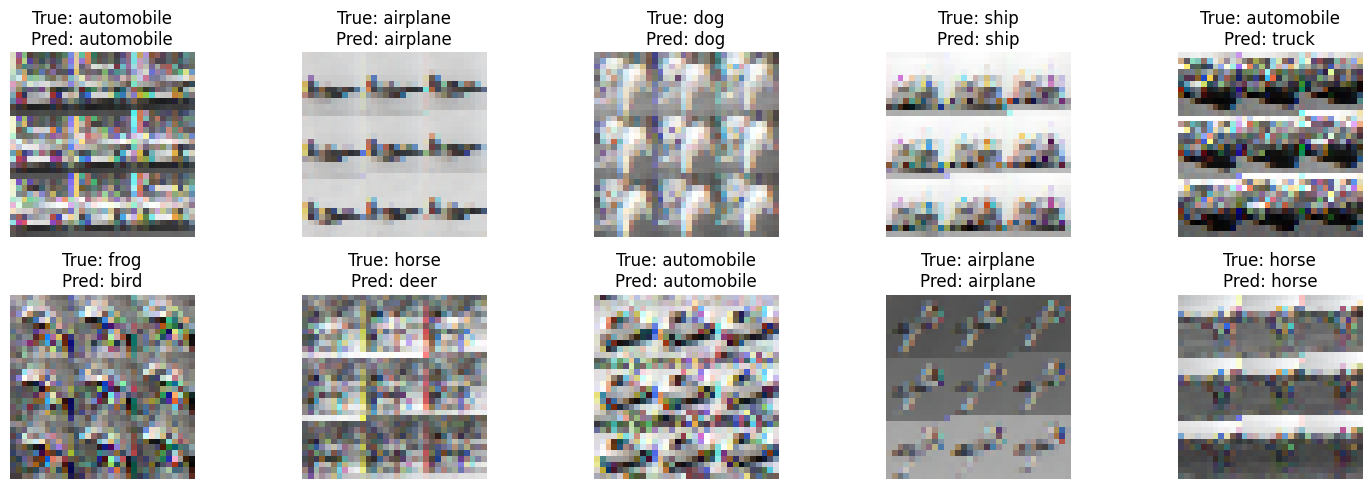

In [2]:
# 随机选择一些验证集中的图像
num_samples = 10
indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[indices]
sample_labels = y_val[indices]

# 进行预测
sample_predictions = np.argmax(model.forward(sample_images), axis=1)

# CIFAR-10 标签
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 绘制图像及其真实标签和预测标签
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    img = sample_images[i].reshape(32, 32, 3)
    img = (img * 255).astype(np.uint8)  # 将图像恢复到原始像素值范围
    plt.imshow(img)
    plt.title(f'True: {cifar10_labels[sample_labels[i]]}\nPred: {cifar10_labels[sample_predictions[i]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
